In [28]:
from jax_renderer_primitives import getProjectionMatrixJax, _build_rasterize_gaussians_fwd_primitive, _build_rasterize_gaussians_bwd_primitive
from diff_gaussian_rasterization import _C as torch_backend

import jax
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as R
import functools
import matplotlib.pyplot as plt
import math
import numpy as np
from random import randint
from tqdm import tqdm
from time import time
import torch

In [29]:
key = jax.random.PRNGKey(67)


In [86]:
rasterizer_fwd_primitive = _build_rasterize_gaussians_fwd_primitive()
rasterizer_bwd_primitive = _build_rasterize_gaussians_bwd_primitive()

import functools

@functools.partial(jax.custom_vjp, nondiff_argnums=(5,6,7,8,9,10,11,12))
def rasterize(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy, near, far
):
    fovX = np.arctan(image_width / 2 / fx) * 2.0
    fovY = np.arctan(image_height / 2 / fy) * 2.0
    tan_fovx = np.tan(fovX)
    tan_fovy = np.tan(fovY)

    pmatrix = getProjectionMatrixJax(image_width, image_height, fx,fy, cx,cy,near,far)
    view_matrix = jnp.transpose(jnp.linalg.inv(jnp.eye(4)))

    projmatrix = view_matrix @ pmatrix

    bg = jnp.zeros(3)
    campos = jnp.zeros(3)
    num_rendered, color, radii, geomBuffer, binningBuffer, imgBuffer = rasterizer_fwd_primitive.bind(
                bg,
                means3D,
                colors_precomp,
                opacity,
                scales,
                rotations,
                view_matrix,
                projmatrix,
                campos,
                tanfovx=tan_fovx, 
                tanfovy=tan_fovy, 
                image_height=image_height, 
                image_width=image_width,  
    )
    return color

def rasterize_fwd(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy, near, far
):
    fovX = np.arctan(image_width / 2 / fx) * 2.0
    fovY = np.arctan(image_height / 2 / fy) * 2.0
    tan_fovx = np.tan(fovX)
    tan_fovy = np.tan(fovY)

    pmatrix = getProjectionMatrixJax(image_width, image_height, fx,fy, cx,cy,near,far)
    view_matrix = jnp.transpose(jnp.linalg.inv(jnp.eye(4)))

    projmatrix = view_matrix @ pmatrix

    bg = jnp.zeros(3)
    campos = jnp.zeros(3)
    num_rendered, color, radii, geomBuffer, binningBuffer, imgBuffer = rasterizer_fwd_primitive.bind(
                bg,
                means3D,
                colors_precomp,
                opacity,
                scales,
                rotations,
                view_matrix,
                projmatrix,
                campos,
                tanfovx=tan_fovx, 
                tanfovy=tan_fovy, 
                image_height=image_height, 
                image_width=image_width,  
    )
    return color, (
        means3D, colors_precomp, opacity, scales, rotations,
        # image_width, image_height, fx,fy, cx,cy,near,far,
        bg,campos,
        num_rendered,
        color,
        radii,
        geomBuffer,
        binningBuffer,
        imgBuffer,
        view_matrix,
        projmatrix
    )

rasterize_fwd_jit = jax.jit(
    rasterize_fwd,
    static_argnums=(5,6,7,8,9,10,11,12)
)
def rasterize_bwd(image_width, image_height, fx,fy, cx,cy, near, far, res, gradients):
    (
        means3D, colors_precomp, opacity, scales, rotations,
        # image_width, image_height, fx,fy, cx,cy,near,far,
        bg,campos,
        num_rendered,
        color,
        radii,
        geomBuffer,
        binningBuffer,
        imgBuffer,
        view_matrix,
        projmatrix
    ) = res
    fovX = np.arctan(image_width / 2 / fx) * 2.0
    fovY = np.arctan(image_height / 2 / fy) * 2.0
    tan_fovx = np.tan(fovX)
    tan_fovy = np.tan(fovY)

    (dL_dmeans3D,
    dL_dmeans2D,
    dL_dcolors,
    dL_dconic,
    dL_dopacity,
    dL_dcov3D,
    dL_dsh,
    dL_dscales,
    dL_drotations) = rasterizer_bwd_primitive.bind(
                bg,
                means3D,
                radii,
                colors_precomp,
                scales,
                rotations,
                view_matrix,
                projmatrix,
                gradients,
                campos,
                geomBuffer,
                num_rendered,
                binningBuffer,
                imgBuffer,
                tanfovx=tan_fovx, 
                tanfovy=tan_fovy,
    )
    return (
        dL_dmeans3D,
        dL_dcolors,
        dL_dopacity,
        dL_dscales,
        dL_drotations,
        None, None, None, None, None, None, None, None
    )
rasterize_bwd_jit = jax.jit(
    rasterize_bwd,
    static_argnums=(0,1,2,3,4,5,6,7,)
)

rasterize.defvjp(rasterize_fwd, rasterize_bwd)

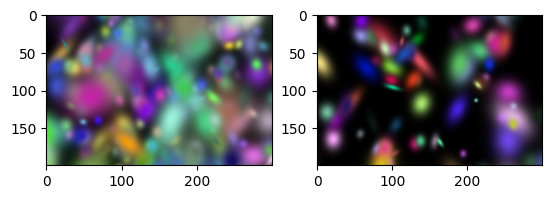

In [87]:
key = jax.random.split(key, 2)[0]


image_width, image_height, fx, fy, cx, cy, near, far = 300, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5
pmatrix = getProjectionMatrixJax(image_width, image_height, fx, fy, cx, cy, near, far)
camera_pose = jnp.eye(4)
view_matrix = jnp.transpose(jnp.linalg.inv(jnp.eye(4)))

projmatrix = view_matrix @ pmatrix

fovX = jnp.arctan(image_width / 2 / fx) * 2.0
fovY = jnp.arctan(image_height / 2 / fy) * 2.0
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)

bg = jnp.zeros(3)
campos = jnp.zeros(3)

N = 100
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
key = jax.random.split(key, 1)[0]
N = means3D.shape[0]
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)

color_gt,_ = rasterize_fwd_jit(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far
)
N = 300
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
key = jax.random.split(key, 1)[0]
N = means3D.shape[0]
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)

color,_ = rasterize_fwd_jit(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far
)

fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color, (1,2,0)))
ax2.imshow(jnp.transpose(color_gt, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


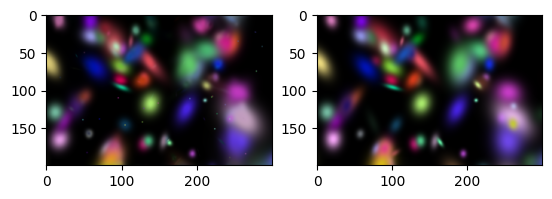

In [89]:
for _ in range(500):
    color, res = rasterize_fwd_jit(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )

    grad_out_color = jnp.array(color - color_gt)

    (
        dL_dmeans3D,
        dL_dcolors,
        dL_dopacity,
        dL_dscales,
        dL_drotations,
    ) = rasterize_bwd_jit(image_width, image_height, fx,fy, cx,cy,near,far, res, grad_out_color)[:5]
    colors_precomp = colors_precomp - dL_dcolors  * 0.0004
    means3D = means3D - dL_dmeans3D  * 0.00001
    scales = scales - dL_dscales  * 0.00001
    rotations = rotations - dL_drotations  * 0.00001
    # opacity = opacity - grad_opacities_jax  * 0.001
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color, (1,2,0)))
ax2.imshow(jnp.transpose(color_gt, (1,2,0)))

In [75]:
res

(Array([[-2.01697111e-01,  4.86418724e-01,  6.29454494e-01],
        [-4.31533694e-01,  2.00543761e-01,  5.74143887e-01],
        [ 1.75815344e-01,  2.43781447e-01,  5.54741502e-01],
        [-3.14736366e-03,  1.29908085e-01,  6.07258081e-01],
        [-2.11484194e-01, -1.42975330e-01,  6.39347672e-01],
        [-1.86848164e-01, -1.55240655e-01,  7.26346374e-01],
        [-3.77423763e-01,  4.72577810e-01,  6.26890302e-01],
        [-4.05213237e-01, -3.12436938e-01,  7.92886138e-01],
        [-4.42409515e-03,  3.89308214e-01,  1.28810430e+00],
        [ 1.43161893e-01,  7.29274750e-03,  9.51918483e-01],
        [-2.32124329e-03, -4.65205669e-01,  1.09987450e+00],
        [ 4.48975444e-01,  4.34713006e-01,  1.19866192e+00],
        [-3.60134840e-01, -3.05940390e-01,  1.38699698e+00],
        [ 1.18984461e-01,  2.89870977e-01,  1.34344304e+00],
        [-1.87925220e-01, -4.51457500e-02,  6.21959567e-01],
        [ 3.96568179e-01, -4.65556383e-02,  1.14302182e+00],
        [ 3.87581229e-01

In [ ]:

def loss(means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far, color_gt):
    color = rasterize(means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far)
    return jnp.mean((color - color_gt)**2)

loss_grad = jax.grad(loss, argnums=(0,1,2,3,4,5,6,7,8,9,10,11,12))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


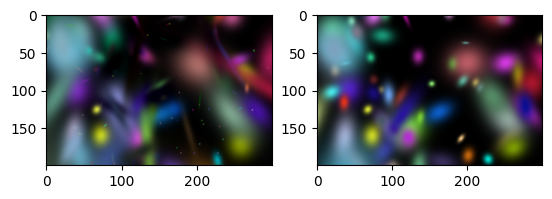

In [22]:
for _ in range(100):
    color, res = rasterize_fwd(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )

    grad_out_color = jnp.array(color - color_gt)

    (dL_dmeans3D,
        dL_dmeans2D,
        dL_dcolors,
        dL_dconic,
        dL_dopacity,
        dL_dcov3D,
        dL_dsh,
        dL_dscales,
        dL_drotations
    ) = rasterize_bwd(image_width, image_height, fx,fy, cx,cy,near,far, res, grad_out_color)

    colors_precomp = colors_precomp - dL_dcolors  * 0.0004
    means3D = means3D - dL_dmeans3D  * 0.000001
    scales = scales - dL_dscales  * 0.00001
    rotations = rotations - dL_drotations  * 0.00001
    # opacity = opacity - grad_opacities_jax  * 0.001
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color, (1,2,0)))
ax2.imshow(jnp.transpose(color_gt, (1,2,0)))